## Preprocessing and Analysis of snRNAseq Data

In this notebook I do quality control, preprocessing, and data analysis of single nuclei sequencing data (gene count matrices) generated by the Smart-seq3xpress protocol. For this I am mainly using the ScanPy module.
**Data used here is of the Whole Cochlea Reference Atlas**

The workflow presented here contains:
- Reading the data
- Removing annotation layers and only reatining some selected annotations
- Quality control (determining outliers by counts as well as mitochondrial genes)
- Normalization using analytic Pearson residuals
- Feature selection
- Dimenstionality reduction and clustering
- UMAP embedding
- Manual cell type annotation
- Visualization of marker expression

Some quick features:
- We filter out genes that occur in <3 cells
- We filter out cells that have < 2000 genes
- We filter out cells that are outside 4 median absolute deviations of distinct gene counts or total gene counts
- We filter out mitochondrial genes (already done in this data set)

In [1]:
# Importing necessary modules for ...
# ... data processing ...
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import scipy.stats as st
import bbknn

# ... plotting ...
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc_context
from matplotlib.colors import ListedColormap
import matplotlib.font_manager as fm
import seaborn as sns

# ... reading and writing files
import sys, os
import json

C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Plotting Configuration

This cell is simply for making pretty plots and defining some folder paths.

In [2]:
# Defining custom color map for plots
with open(r".\ColorMap.csv", "r") as file:
    my_cmap_df = pd.read_csv(file, header=0)
    my_cmap = ListedColormap(my_cmap_df["HEX_Code"].to_list())

# Defining save location for plots
figures_folder = r"C:\Users\Johann\Documents\.Personal\05 Studium\02 Tübingen Neuroscience MSc\03 Lectures\04_SS_25\02_Master_Thesis\05_Figures"

# Defining folder where raw data is stored
data_folder = r"C:\Users\Johann\Documents\.Personal\05 Studium\02 Tübingen Neuroscience MSc\03 Lectures\04_SS_25\02_Master_Thesis\03_Data\01 Sequencing Data"

# Adding custom font
fonts= [r".\Arimo\Arimo-Regular.ttf",
        r".\Arimo\Arimo-SemiBold.ttf",
        r".\Arimo\Arimo-Italic.ttf",
        r".\Arimo\Arimo-SemiBoldItalic.ttf"]
for font in fonts:
    fm.fontManager.addfont(font)

# Setting parameters for ScanPy plots
sc.set_figure_params(
    dpi_save= 600,
    facecolor= "white",
    color_map= "RdPu")

scale = 1.4 #plot scale factor
fig_width = 2.35*scale

plt.rcParams["font.family"] = "Arimo"
plt.rcParams["figure.facecolor"] = (1.0, 1.0, 1.0, 0.0)
plt.rcParams["axes.labelsize"] = 6*scale
plt.rcParams["axes.labelweight"] = "semibold"
plt.rcParams["axes.facecolor"] = (1.0, 1.0, 1.0, 0.7)
plt.rcParams["xtick.labelsize"] = 6*scale
plt.rcParams["ytick.labelsize"] = 6*scale
plt.rcParams["axes.titlesize"] = 8*scale
plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams["axes.titleweight"] = "semibold"
plt.rcParams["legend.fontsize"] = 6*scale

### Reading Data

We read the data from an .h5ad file that contains the raw count matrix with some annotations and metadata.

Information carried over is:
- plate ID (a unique barcode for each 384-well plate sequenced)
- age of animals
- pre-annotated cell types (for UMAP and detailed projection)
- pre-annotated cell types corrected with batch integration
- UMAP embedding corrected with batch integration

In [3]:
# Reading the data
adata_original = sc.read_h5ad(data_folder + r"\CBA_3mo_CompleteCochlea_Atlas_Annotated.h5ad")

# Making a clean copy ...
adata = ad.AnnData(adata_original.layers["umi_raw"].copy()) # Copying over the raw counts

# ... and preserving some of the metadata as well as prior cell type annotations
adata.obs["plate"] = adata_original.obs["plateBC"].values
adata.obs["age"] = "3 months"
adata.obs["cell_types_danny"] = adata_original.obs["cell_types_for_UMAP"].values
adata.obsm["X_umap_danny"] = adata_original.obsm["X_umap"].copy()
adata.obs.set_index(adata_original.obs.index, inplace= True)
adata.var.set_index(adata_original.var.index, inplace= True)

# Removing potential duplicates
adata.obs_names_make_unique()
adata.var_names_make_unique()

adata

AnnData object with n_obs × n_vars = 4807 × 15095
    obs: 'plate', 'age', 'cell_types_danny'
    obsm: 'X_umap_danny'

In [4]:
# Getting SGN plates from other dataset to annotate sample origin
adata_SGNonly = sc.read_h5ad(data_folder + r"\CBA_3mo_SGN.h5ad")

total_plates = set(adata.obs["plate"])
plates_SGN = set(adata.obs["plate"]).intersection(set(adata_SGNonly.obs["plate"]))
print(f"Identified {len(plates_SGN)} (out of {len(total_plates)}) plates containing SGNs:\n{plates_SGN}")

adata.obs["sample"] = "OC"
adata.obs.loc[adata.obs["plate"].isin(plates_SGN), "sample"] = "SGN"
adata.obs["sample"].value_counts()

Identified 16 (out of 27) plates containing SGNs:
{11101452, 11101383, 11176492, 11101453, 11101389, 11101390, 11176493, 11176495, 11101841, 11176496, 11176497, 11176498, 11101840, 11101971, 11101967, 11176189}


sample
SGN    2569
OC     2238
Name: count, dtype: int64

### Quality Control

We calculate quality control metrics.

In [5]:
# Define mitochondrial, ribosomal, and hemoglobin genes by name
# (mito are already filtered out in this dataset ...)
adata.var["mt"] = adata.var_names.str.startswith("mt-")
adata.var["ribo"] = adata.var_names.str.startswith(("Rpl", "Rps"))
adata.var["hb"] = adata.var_names.str.startswith("Hb")

print(f"{len(adata.var_names[adata.var["mt"]])} Mitochondrial genes identified:\n", adata.var_names[adata.var["mt"]].values, "\n")
print(f"{len(adata.var_names[adata.var["ribo"]])} Ribosomal genes identified:\n", adata.var_names[adata.var["ribo"]].values, "\n")
print(f"{len(adata.var_names[adata.var["hb"]])} Hemoglobin genes identified:\n", adata.var_names[adata.var["hb"]].values)

# Calculating QC metrics including the gene subsets
sc.pp.calculate_qc_metrics(adata, qc_vars= ["mt", "ribo", "hb"],
                           inplace= True,
                           log1p= True)

adata.obs

0 Mitochondrial genes identified:
 [] 

9 Ribosomal genes identified:
 ['Rplp0' 'Rplp1' 'Rplp2' 'Rpsa' 'Rpsa.ps10' 'Rpsa.ps12' 'Rpsa.ps2'
 'Rpsa.ps7' 'Rpsa.ps9'] 

11 Hemoglobin genes identified:
 ['Hba-a1' 'Hba-a2' 'Hba.a1' 'Hba.a2' 'Hbb-bs' 'Hbb-bt' 'Hbb.bs' 'Hbb.bt'
 'Hbegf' 'Hbp1' 'Hbs1l']


plate       age cell_types_danny sample  \
AACCACATCGACAACTCGAA  11101383  3 months            mSC_1    SGN   
AACCACATCGAGGTGTCGAG  11101383  3 months            mSC_1    SGN   
AACCACATCGATCCAAGGAA  11101383  3 months      Fibrocyte_4    SGN   
AACCACATCGCACGGTGGTT  11101383  3 months      Fibrocyte_4    SGN   
AACCACATCGCCTATCCTTA  11101383  3 months            mSC_1    SGN   
...                        ...       ...              ...    ...   
TTCCATCGGATGTCCTACTA  11101389  3 months            SGC_1    SGN   
TTCCTTCGAGACCACCATAA  11101389  3 months            SGC_2    SGN   
TTCCTTCGAGCAGTGGAGCT  11101389  3 months            SGC_1    SGN   
TTCTCACTCTTACAACCTCA  11101389  3 months            SGC_1    SGN   
TTGAACTGAGTTGTCACGTT  11101389  3 months            SGC_1    SGN   

                      n_genes_by_counts  log1p_n_genes_by_counts  \
AACCACATCGACAACTCGAA               1413                 7.254178   
AACCACATCGAGGTGTCGAG               2229                 7.709757   
AACCACATCGATCCAAGGAA               1865                 7.531552   
AACCACATCGCACGGTGGTT               3234                 8.081784   
AACCACATCGCCTATCCTTA               3305                 8.103494   
...                                 ...                      ...   
TTCCATCGGATGTCCTACTA               1884                 7.541683   
TTCCTTCGAGACCACCATAA               1179                 7.073270   
TTCCTTCGAGCAGTGGAGCT               5127                 8.542471   
TTCTCACTCTTACAACCTCA               3426                 8.139441   
TTGAACTGAGTTGTCACGTT               5092                 8.535622   

                      total_counts  log1p_total_counts  \
AACCACATCGACAACTCGAA        2549.0            7.843849   
AACCACATCGAGGTGTCGAG        4342.0            8.376321   
AACCACATCGATCCAAGGAA        2935.0            7.984803   
AACCACATCGCACGGTGGTT        9453.0            9.154193   
AACCACATCGCCTATCCTTA       11379.0            9.339613   
...                            ...                 ...   
TTCCATCGGATGTCCTACTA        4305.0            8.367765   
TTCCTTCGAGACCACCATAA        1716.0            7.448334   
TTCCTTCGAGCAGTGGAGCT       24298.0           10.098190   
TTCTCACTCTTACAACCTCA       13710.0            9.525954   
TTGAACTGAGTTGTCACGTT       31239.0           10.349455   

                      pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AACCACATCGACAACTCGAA                   17.379364                    26.167124   
AACCACATCGAGGTGTCGAG                   13.657301                    20.497467   
AACCACATCGATCCAAGGAA                   18.500852                    24.804089   
AACCACATCGCACGGTGGTT                   17.920237                    23.981805   
AACCACATCGCCTATCCTTA                   18.437473                    25.652518   
...                                          ...                          ...   
TTCCATCGGATGTCCTACTA                   14.819977                    22.787456   
TTCCTTCGAGACCACCATAA                   17.074592                    26.282051   
TTCCTTCGAGCAGTGGAGCT                   17.120751                    23.652152   
TTCTCACTCTTACAACCTCA                   19.635303                    27.024070   
TTGAACTGAGTTGTCACGTT                   16.649060                    24.011652   

                      ...  pct_counts_in_top_500_genes  total_counts_mt  \
AACCACATCGACAACTCGAA  ...                    64.182032              0.0   
AACCACATCGAGGTGTCGAG  ...                    50.644864              0.0   
AACCACATCGATCCAAGGAA  ...                    53.492334              0.0   
AACCACATCGCACGGTGGTT  ...                    49.624458              0.0   
AACCACATCGCCTATCCTTA  ...                    54.969681              0.0   
...                   ...                          ...              ...   
TTCCATCGGATGTCCTACTA  ...                    57.560976              0.0   
TTCCTTCGAGACCACCATAA  ...                    60.431235              0.0   
TTCCTTCGAGCAGTGGAGCT  ...                    4

In [6]:
# Calculating MAD for a given QC metric
def is_outlier(adata, metric: str, nmads: int):
    '''This function calculates whether each element of a list or series is an
    outlier based on the number of median absolute deviations (MADs) passed in the
    argument nmads. It returns a list of booleans where each element that was an outlier
    in the original list results in a TRUE in the returned list. If you use the returned
    list for indexing to EXCLUDE outliers, remember to index with the inverse (~outliers) of the outlier
    list returned by this function'''
    M = adata.obs[metric]
    outlier = ((M < np.median(M) - nmads * st.median_abs_deviation(M)) # outlier if below ...
               | (np.median(M) + nmads * st.median_abs_deviation(M) < M)) # and outlier if above
    return outlier

# Defining whether a nucleus is an outlier based on total counts and gene counts per cell
adata.obs["outlier"] = (is_outlier(adata, "log1p_total_counts", 4)
                        | is_outlier(adata, "log1p_n_genes_by_counts", 4)
                        | (adata.obs["n_genes_by_counts"] < 2000)) # Custom hard threshold for minimum gene number per nucleus due to Smart-seq3xpress performance

# Running doublet detection and creating a doublet score for every cell
sc.pp.scrublet(adata, batch_key= "age")

print(f"Identified {len(adata.obs[adata.obs["outlier"]])} out of {len(adata.obs)} nuclei as outliers.\n")

Identified 980 out of 4807 nuclei as outliers.



C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\plotting\_anndata.py:967: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\plotting\_anndata.py:967: UserWarning: The palette list has more values (45) than needed (1), which may not be intended.
  sns.violinplot(
C:\Users\Johann\AppData\Local\Temp\ipykernel_1740\2282657710.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(["Single Nuclei"])
C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCa

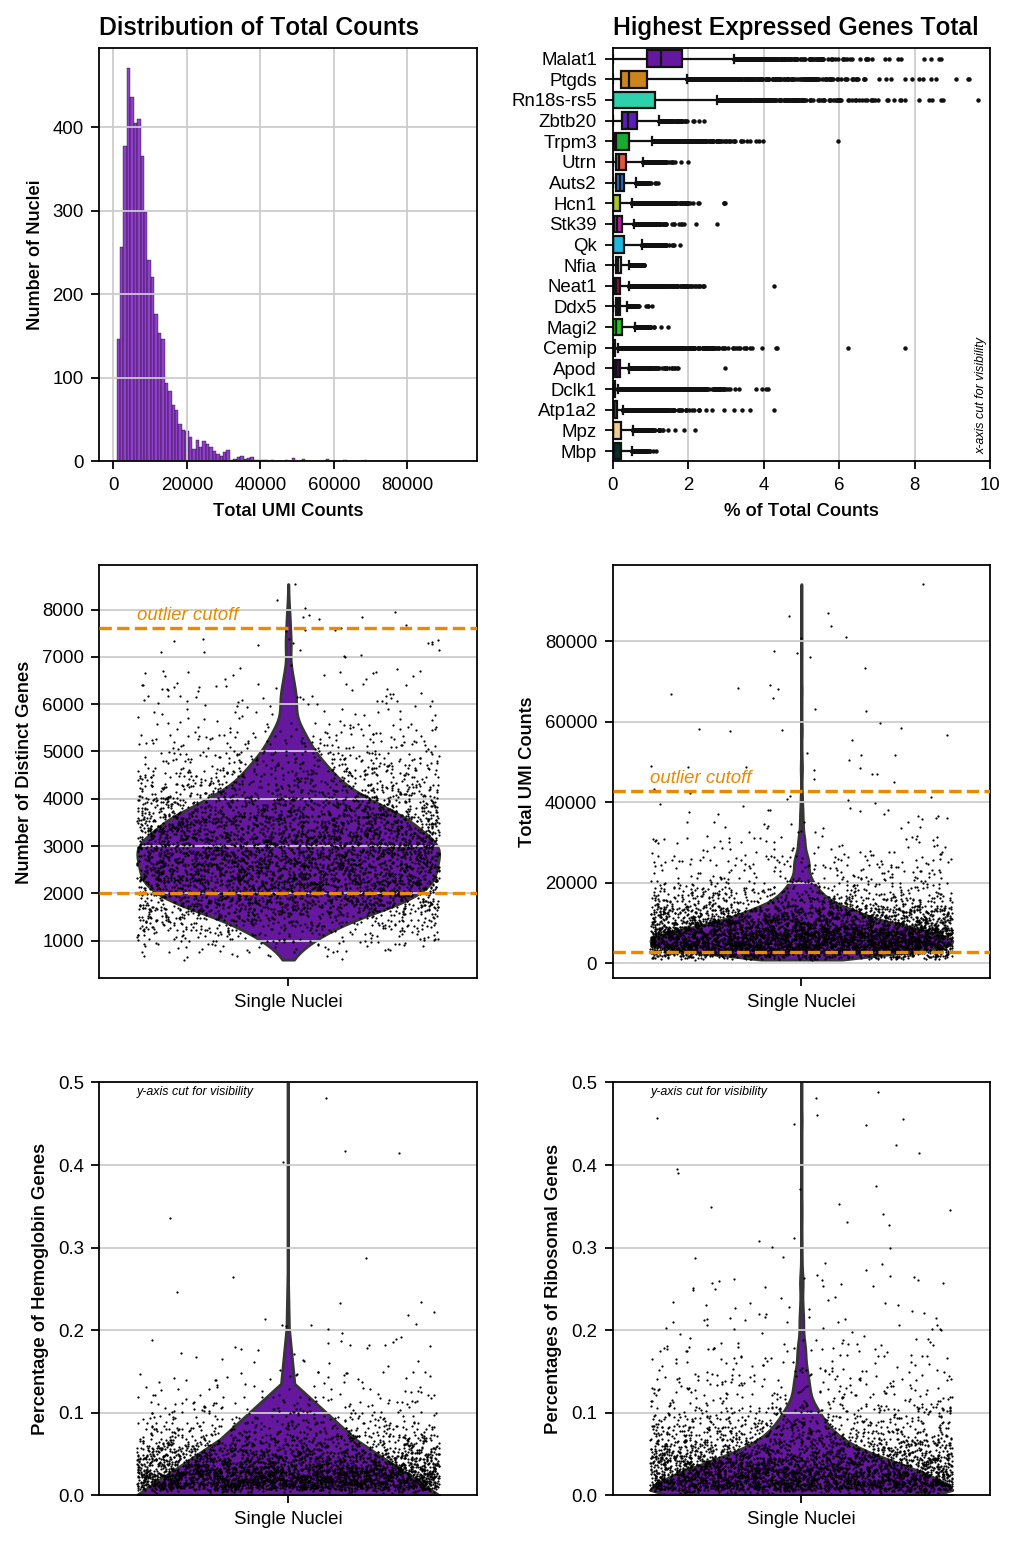

In [7]:
# Plotting Quality Control metrics
fig, axes = plt.subplots(3, 2, figsize=(fig_width*2, fig_width*3), layout= "constrained")

sc.pl.violin(adata, ["n_genes_by_counts"], jitter= 0.4, ax= axes[1, 0], show= False, palette = my_cmap.colors)
axes[1, 0].set_xticklabels(["Single Nuclei"])
axes[1, 0].set_ylabel("Number of Distinct Genes")
axes[1, 0].axhline(adata[~adata.obs["outlier"]].obs["n_genes_by_counts"].min(),
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[1, 0].axhline(adata[~adata.obs["outlier"]].obs["n_genes_by_counts"].max(),
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[1, 0].text(-0.4, adata[~adata.obs["outlier"]].obs["n_genes_by_counts"].max()+170, "outlier cutoff",
                color= my_cmap.colors[1],
                fontsize= 6*scale,
                fontstyle= "italic")

sc.pl.violin(adata, ["total_counts"], jitter= 0.4, ax= axes[1, 1], show= False, palette = my_cmap.colors)
axes[1, 1].set_xticklabels(["Single Nuclei"])
axes[1, 1].set_ylabel("Total UMI Counts")
axes[1, 1].axhline(adata[~adata.obs["outlier"]].obs["total_counts"].min(),
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[1, 1].axhline(adata[~adata.obs["outlier"]].obs["total_counts"].max(),
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[1, 1].text(-0.4, adata[~adata.obs["outlier"]].obs["total_counts"].max()+2000, "outlier cutoff",
                color= my_cmap.colors[1],
                fontsize= 6*scale,
                fontstyle= "italic")

sc.pl.violin(adata, ["pct_counts_hb"], jitter= 0.4, ax= axes[2, 0], show= False, palette = my_cmap.colors)
axes[2, 0].set_xticklabels(["Single Nuclei"])
axes[2, 0].set_ylabel("Percentage of Hemoglobin Genes")
axes[2, 0].set_ylim(0, 0.5)
axes[2, 0].text(-0.4, 0.485, "y-axis cut for visibility",
                color= "black",
                fontsize= 4*scale,
                fontstyle= "italic")

sc.pl.violin(adata, ["pct_counts_ribo"], jitter= 0.4, ax= axes[2, 1], show= False, palette = my_cmap.colors)
axes[2, 1].set_xticklabels(["Single Nuclei"])
axes[2, 1].set_ylabel("Percentages of Ribosomal Genes")
axes[2, 1].set_ylim(0, 0.5)
axes[2, 1].text(-0.4, 0.485, "y-axis cut for visibility",
                color= "black",
                fontsize= 4*scale,
                fontstyle= "italic")

sc.pl.highest_expr_genes(adata, n_top=20, ax= axes[0, 1], show= False, palette= my_cmap.colors)
axes[0, 1].set_title("Highest Expressed Genes Total")
axes[0, 1].set_xlim(0, 10)
axes[0, 1].set_xlabel(r"% of Total Counts")
axes[0, 1].text(9.6, 19, "x-axis cut for visibility",
                color= "black",
                fontsize= 4*scale,
                rotation= 90,
                fontstyle= "italic")

sns.histplot(adata.obs["total_counts"], bins = 100, kde= False, ax= axes[0, 0], color= my_cmap.colors[0])
axes[0, 0].set_title("Distribution of Total Counts")
axes[0, 0].set_xlabel("Total UMI Counts")
axes[0, 0].set_ylabel("Number of Nuclei")

fig.tight_layout(h_pad= 1.0*scale)
fig.savefig(figures_folder + r"\QC_metrics_ReferenceAtlas.png")
plt.show()

### Normalization

We normalize counts using analytical pearson residuals.

In [8]:
# Saving a copy of the raw counts before normalising
adata.layers["raw_counts"] = adata.X.copy()

C:\Users\Johann\AppData\Local\Temp\ipykernel_1740\1719846391.py:13: UserWarning: The palette list has more values (45) than needed (1), which may not be intended.
  sns.histplot(adata.X.sum(1), bins = 100, kde= False, ax= axes[0], palette= my_cmap.colors, legend= False)
C:\Users\Johann\AppData\Local\Temp\ipykernel_1740\1719846391.py:20: UserWarning: The palette list has more values (45) than needed (1), which may not be intended.
  sns.histplot(adata.layers["log1p_normalized_counts"].sum(1), bins = 100, kde= False, ax= axes[2], palette= my_cmap.colors, legend= False)


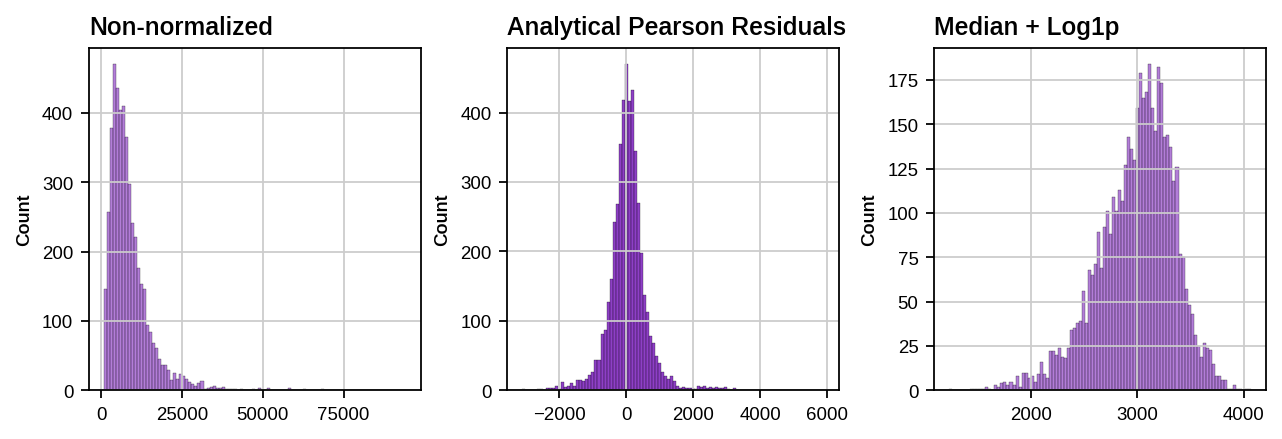

In [9]:
# Normalizing the counts
# ... by pearson residulals ...
adata.layers["pearson_normalized_counts"] = sc.experimental.pp.normalize_pearson_residuals(adata, copy= True).X

# ... and by median (with log1p transformation)
adata.layers["log1p_normalized_counts"] = sc.pp.normalize_total(adata, copy= True).X
sc.pp.log1p(adata, layer= "log1p_normalized_counts")

# Plotting distributions after normalization
fig, axes = plt.subplots(1, 3, figsize=(fig_width*2.4, fig_width*0.8), layout= "constrained")

# the original layer remains raw
sns.histplot(adata.X.sum(1), bins = 100, kde= False, ax= axes[0], palette= my_cmap.colors, legend= False)
axes[0].set_title("Non-normalized")

sns.histplot(adata.layers["pearson_normalized_counts"].sum(1), bins = 100, kde= False, ax= axes[1], color= my_cmap.colors[0])
axes[1].set_title("Analytical Pearson Residuals")


sns.histplot(adata.layers["log1p_normalized_counts"].sum(1), bins = 100, kde= False, ax= axes[2], palette= my_cmap.colors, legend= False)
axes[2].set_title("Median + Log1p")

plt.show()
fig.savefig(figures_folder + r"\Normalization_Comparison_ReferenceAtlas.png")

### Feature Selection

We select the top 2000 most highly variable genes (HVGs) based on pearson normalized and median normalized data and save the annotation so separate fields.

**DO NOT RUN THE FOLLOWING CELL TWICE WITHOUT RELOADING THE DATA OR RESTARTING THE KERNEL**

In [10]:
# Feature selection based on pearson residuals (uses the raw counts by default) ...
sc.experimental.pp.highly_variable_genes(adata, n_top_genes= 2000, batch_key= "age")

# ... and based on log1p normalized counts
if "log1p_highly_variable" in adata.obs_names.values:
    pass
else:
    # This very confusing code block simply makes it so that the
    # highly variable gene metrics calculated from the log1p shifted data are saved to their own
    # separate fields
    adata.var = pd.concat((adata.var,
                        sc.pp.highly_variable_genes(adata, n_top_genes= 2000,
                                                    layer= "log1p_normalized_counts",
                                                    inplace= False).rename(
                                                        columns={"highly_variable": "log1p_highly_variable",
                                                                    "means": "log1p_means",
                                                                    "dispersions": "log1p_dispersions",
                                                                    "dispersions_norm": "log1p_dispersions_norm"}).loc[:, ["log1p_highly_variable", "log1p_means", "log1p_dispersions", "log1p_dispersions_norm"]]), axis=1)

C:\Users\Johann\AppData\Local\Temp\ipykernel_1740\205391384.py:4: UserWarning: The palette list has more values (45) than needed (2), which may not be intended.
  sns.scatterplot(adata.var, x= "means", y= "residual_variances",
C:\Users\Johann\AppData\Local\Temp\ipykernel_1740\205391384.py:17: UserWarning: The palette list has more values (45) than needed (2), which may not be intended.
  sns.scatterplot(adata.var, x= "log1p_means", y= "log1p_dispersions",


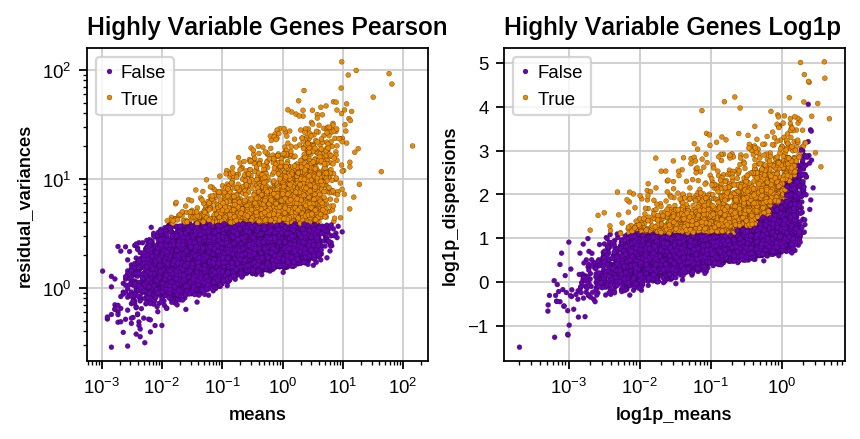

In [11]:
# Plotting highly variable gene fraction
fig, ax = plt.subplots(1,2, figsize=(fig_width*1.6, fig_width*0.8), layout= "constrained")

sns.scatterplot(adata.var, x= "means", y= "residual_variances",
                hue= "highly_variable", 
                palette= my_cmap.colors,
                ax= ax[0], 
                s= 5,
                edgecolor= "black",
                linewidth= 0.1,
                zorder= 2)
ax[0].set_title("Highly Variable Genes Pearson")
ax[0].legend()
ax[0].set_xscale("log")
ax[0].set_yscale("log")

sns.scatterplot(adata.var, x= "log1p_means", y= "log1p_dispersions",
                hue= "log1p_highly_variable",
                palette= my_cmap.colors,
                ax= ax[1],
                s= 5,
                edgecolor= "black",
                linewidth= 0.1,
                zorder= 2)
ax[1].set_title("Highly Variable Genes Log1p")
ax[1].set_xscale("log")
ax[1].legend()

fig.savefig(figures_folder + r"\HVGs_ReferenceAtlas.png")

### Dimensionality Reduction

We compute principal components on the pearson normalized count matrix.

C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\plotting\_tools\scatterplots.py:468: UserWarning: Adding colorbar to a different Figure <Figure size 789.6x210.56 with 4 Axes> than <Figure size 320x320 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(


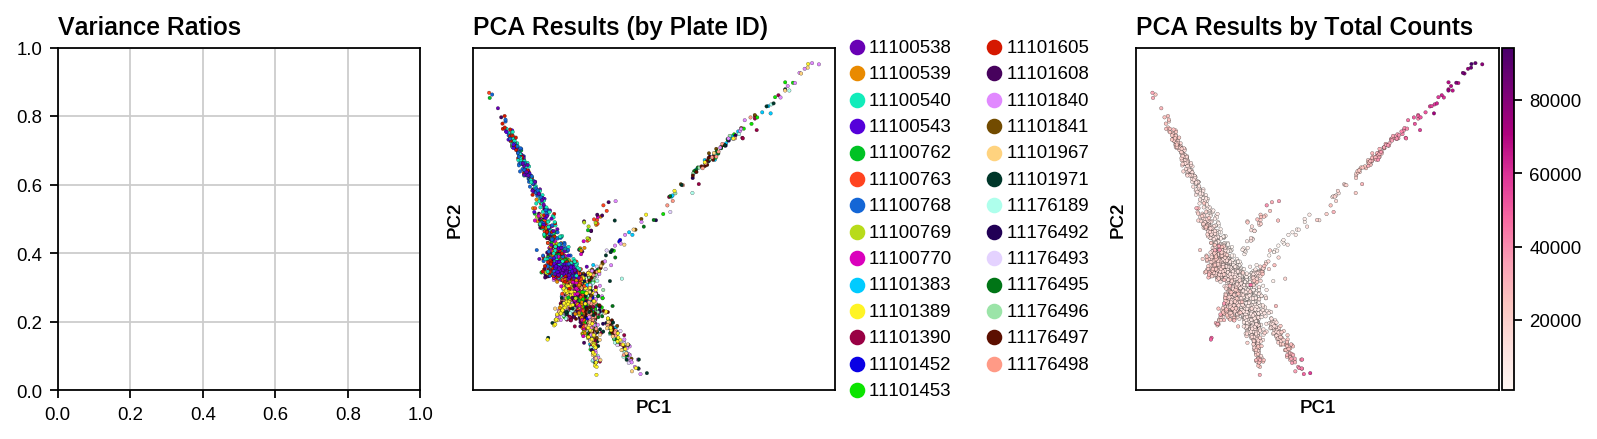

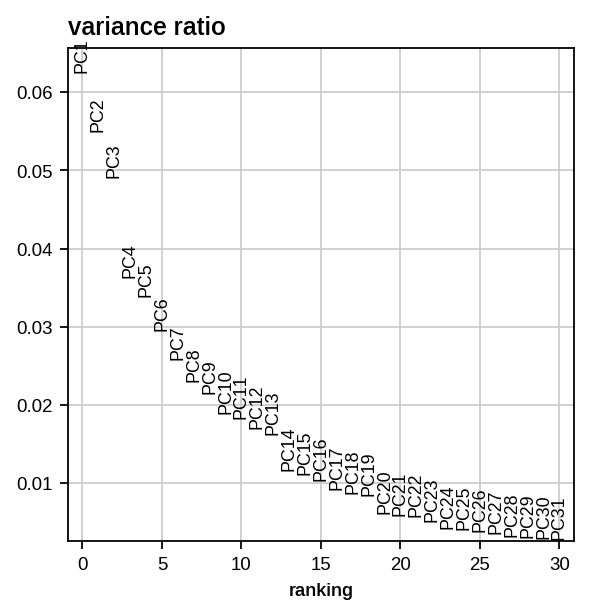

In [12]:
# Computing PCA with pearson residuals on the raw count matrix
adata.X = adata.layers["raw_counts"].copy()
sc.experimental.pp.normalize_pearson_residuals_pca(adata)
# sc.pp.pca(adata, use_highly_variable= True, svd_solver= "arpack")

# We inspect the PCA results
fig, axes = plt.subplots(1, 3, figsize=(fig_width*3, fig_width*0.8), layout= "constrained")

sc.pl.pca_variance_ratio(adata, show= False)
axes[0].set_title("Variance Ratios")

sc.pl.pca_scatter(adata, color= "plate",
                  palette= my_cmap.colors,
                  s= 10,
                  edgecolor= "black",
                  linewidth= 0.1,
                  ax= axes[1],
                  show= False)
axes[1].set_title("PCA Results (by Plate ID)")

sc.pl.pca_scatter(adata, color= "total_counts",
                  s= 10,
                  edgecolor= "black",
                  linewidth= 0.1,
                  ax= axes[2],
                  show= False)
axes[2].set_title("PCA Results by Total Counts")

fig.savefig(figures_folder + r"\PCA_Results_ReferenceAtlas.png")
plt.show()

### UMAP Embedding

We batch correct the data by calculating a batch-balances k-nearest neighbor (BBKNN) graph and calculate a UMAP projection.
The batch covariate is the plateID, so we correct for differences between each plate.

In [13]:
# BBKNN embedding
adata.X = adata.layers["pearson_normalized_counts"].copy()
# sc.pp.neighbors(adata)
bbknn.bbknn(adata, batch_key= "plate", neighbors_within_batch= 3)

# UMAP Embedding
sc.tl.umap(adata, min_dist= 1, spread= 1.3)

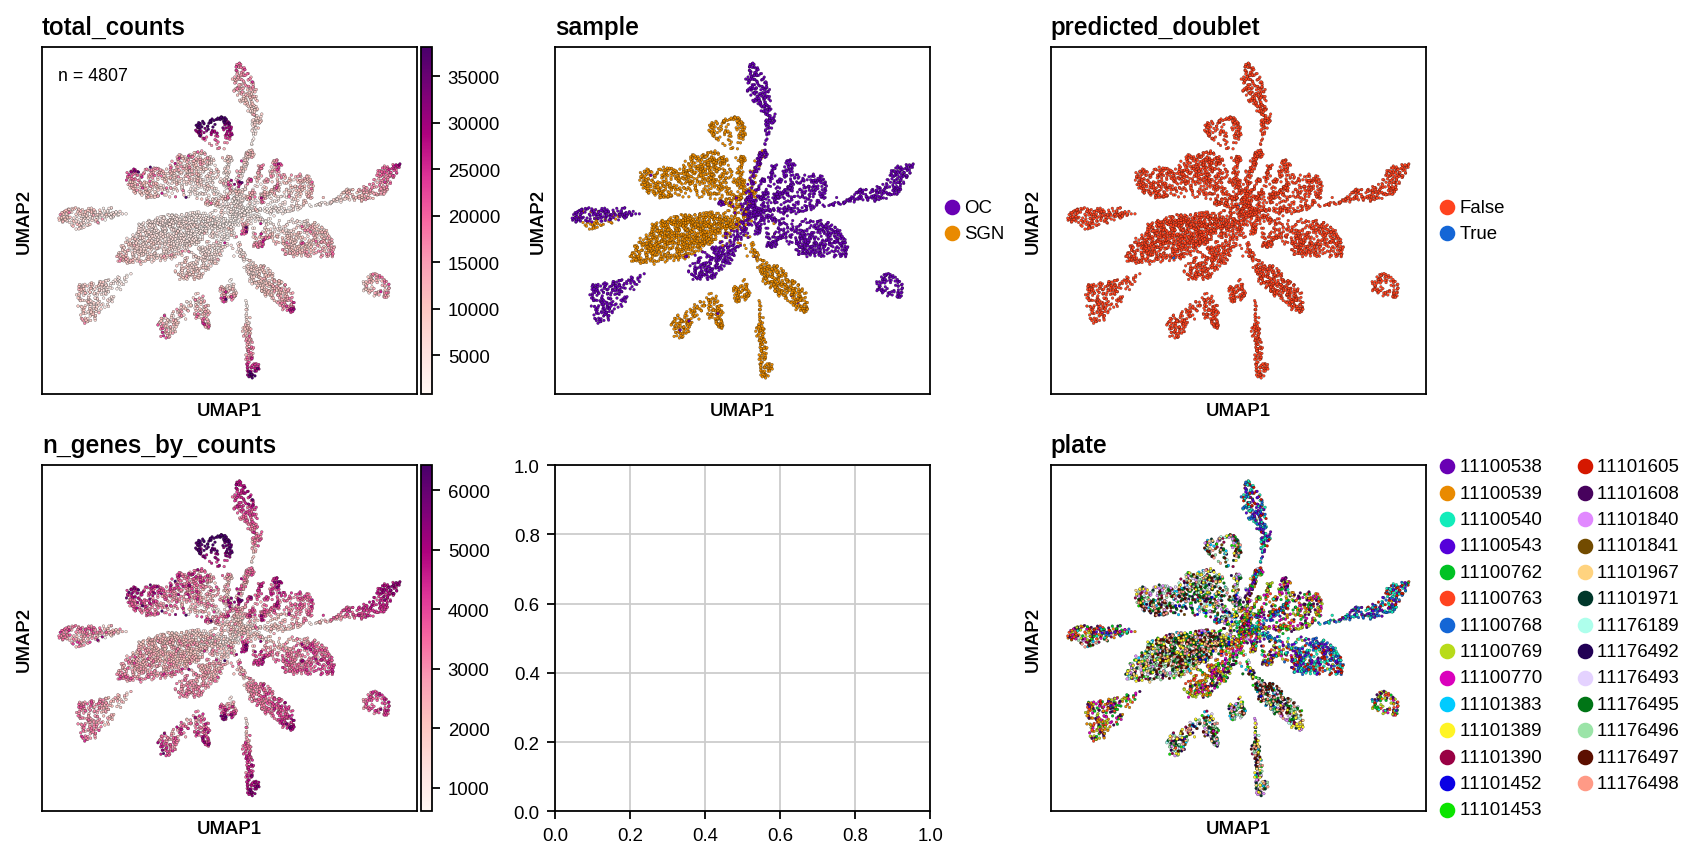

In [14]:
# Plotting before filtering
fig, axs = plt.subplots(2, 3, figsize= (fig_width*3.2, fig_width*1.6), layout= "compressed")

dot_size = 6
vmax = "p99"
sc.pl.umap(adata,
           color=["total_counts"],
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[0, 0],
           show= False)
axs[0, 0].text(-16,20, f"n = {adata.n_obs}", size= 8)

sc.pl.umap(adata,
           color=["n_genes_by_counts"],
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[1, 0],
           show= False)

sc.pl.umap(adata,
           color=["predicted_doublet"],
           palette= my_cmap.colors[5:],
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[0, 2],
           show= False)

sc.pl.umap(adata,
           color=["sample"],
           palette= my_cmap.colors,
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[0, 1],
           show= False)

sc.pl.umap(adata,
           color=["plate"],
           palette= my_cmap.colors,
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[1, 2],
           show= False)

fig.savefig(figures_folder + r"\UMAP_Prefilter_ReferenceAtlas.png")
plt.show()

### Filtering

We filter out cells and genes that we determined to be outliers as defined above.<br>
Exclusion criteria:
- total genes counts outside of 4 MADs in positive or negative direction
- less than 2000 genes expressed per nucleus (due to Smart-seq3xpress performance)
- single genes expressed in less than 3 cells in data set
- all mitochondrial genes

In [15]:
# And this is also what we have to do with out custom "outlier" annotations
print(f"Number of nuclei before outliers: {adata.n_obs}")
adata = adata[(~adata.obs["outlier"])]
print(f"Number of nuclei after outliers: {adata.n_obs}\n")

print(f"Number of nuclei before count exclusion: {len(adata.obs)}")
sc.pp.filter_genes(adata, min_cells= 3, inplace= True)
print(f"Number of cells after count exclusion: {len(adata.obs)}")

Number of nuclei before outliers: 4807
Number of nuclei after outliers: 3827

Number of nuclei before count exclusion: 3827


C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\preprocessing\_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Number of cells after count exclusion: 3827


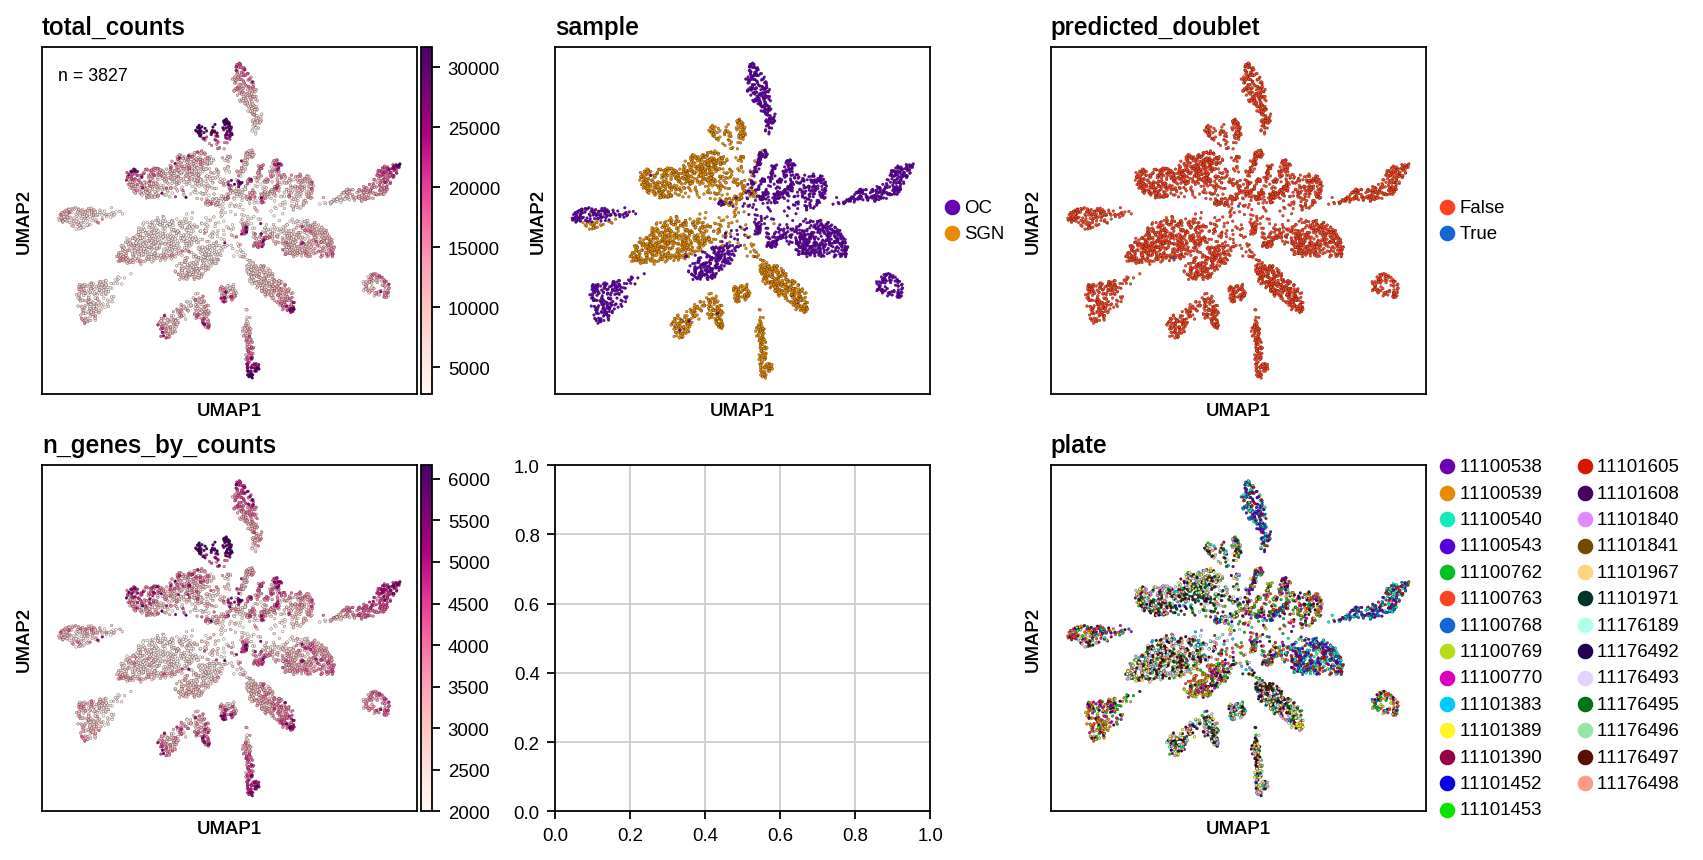

In [32]:
# Plotting after filtering
fig, axs = plt.subplots(2, 3, figsize= (fig_width*3.2, fig_width*1.6), layout= "compressed")

dot_size = 6
vmax = "p99"
sc.pl.umap(adata,
           color=["total_counts"],
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[0, 0],
           show= False)
axs[0, 0].text(-16,20, f"n = {adata.n_obs}", size= 8)

sc.pl.umap(adata,
           color=["n_genes_by_counts"],
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[1, 0],
           show= False)

sc.pl.umap(adata,
           color=["predicted_doublet"],
           palette= my_cmap.colors[5:],
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[0, 2],
           show= False)

sc.pl.umap(adata,
           color=["sample"],
           palette= my_cmap.colors,
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[0, 1],
           show= False)

sc.pl.umap(adata,
           color=["plate"],
           palette= my_cmap.colors,
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[1, 2],
           show= False)

fig.savefig(figures_folder + r"\UMAP_Postfilter_ReferenceAtlas.png")
plt.show()

### Clustering

We cluster using the Leiden algorithm.

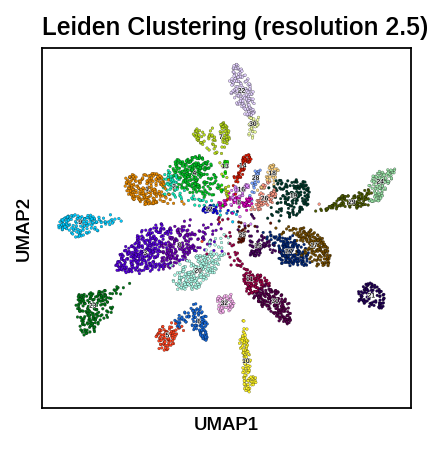

In [33]:
adata.X = adata.layers["pearson_normalized_counts"].copy() # The leiden() function requires normalized counts

# Clustering ...
sc.tl.leiden(adata,
             flavor= "igraph",
             n_iterations= -1, # iterate until the best clusters have been found
             resolution= 2.5, # higher number means finer clusters
             key_added= "leiden")

# Plotting the clusters
fig, ax = plt.subplots(1,1, figsize= (fig_width*0.9, fig_width*0.9))

sc.pl.umap(adata, color= ["leiden"],
           palette= my_cmap.colors,
           size= 6,
           edgecolor= "black",
           linewidth= 0.1,
           legend_loc= "on data",
           legend_fontsize = 3,
           legend_fontoutline = 0.4,
           title= "Leiden Clustering (resolution 2.5)",
           ax= ax,
           show= False)

fig.savefig(figures_folder + r"\Leiden_Clustering_ReferenceAtlas.png")
plt.show()

### Annotation

We annotate from a list of marker genes.

In [35]:
# Marker genes
markers = {"Hair Cells": ["Myo6", "Myo7a", "Cib2", "Ocm", "Pou4f3"],
           "Inner Hair Cells": ["Slc17a8", "Otof"],
           "Outer Hair Cells": ["Slc26a5", "Ikzf2", "Kcnq4", "Strc"],
           "Deiter Cells": ["Crhr1", "Gdf6", "Plxnb2", "Fabp3", "Fgfr3", "Ceacam16"],
           "Inner Pillar Cells": ["Fgfr3", "Lgr5", "Bmp6"], # Bmp6 negative marker
           "Outer Pillar Cells": ["Fgfr3", "Cd44"],
           "Inner Phalangeal Cells": ["Slc1a3", "Cpa6", "Far1", "Otog", "Gpc2"],
           "Claudius Cells": ["Aqp4", "Cobl", "Rspo2", "Car12", "Otoa"], # Car12 negative marker
           "Hensen Cells": ["Zbtb20", "Lockd", "Dpysl4", "Cobl", "Cd44"], # Cd44 negative marker
           "Boettcher Cells": ["Car12", "Rspo2"],
           "Inner Sulcus Cells": ["Aqp4", "Cd44 ", "Bmp4"],
           "Interdental Cells": ["Otoa", "Ceacam16"],
           "Macrophages": ["Fcgr3", "Csf1r", "Lgmn", "C1qb", "Mrc1", "Ptprc", "C1qb"],
           "Endothelial Cells": ["Flt1", "Tie1", "Ly6c", "Esam", "Cdh5", "Pecam"],
           "Pericytes": ["Rgs5", "Pdgfrb", "Cspg4"],
           "Intermediate Cells": ["Kcnj10", "Dct", "Col5a3"],
           "Marginal Cells": ["Kcne1", "Bsnd"],
           "Basal Cells": ["Cldn11", "Atp6v0a4"],
           "Spindle Cells": ["Slc26a4", "Anxa1", "Dpp10"], #Slc26a4 strong in both Spindle and Root Cells
           "Root Cells": ["Slc26a4", "Lgr5", "Epyc"],
           "Reissner Cells": ["Lmx1a", "Frem2", "Slc26a7"],
           "Tympanic Border Cells": ["Emilin2", "Rarres1", "Emcn", "Otor"],
           "Osteoblast": ["Runx2", "Satb2", "Dio2", "Dlx5", "Bglap"],
           "Osteocyte": ["Phex", "Sfrp4", "Fxyd5"],
           "Chondrocytes": ["Prg4", "Fn1", "Clu"],
           "Fibrocytes": ["Coch", "Otos", "Car3", "Col1a2", "Slco1c1"],
           "Fibroblast": ["Dcn", "Lum"],
           "Fibrocyte I": ["Car2", "Col9a2", "Slc4a11"],
           "Fibrocyte II": ["Atp1a2"],
           "Fibrocyte III": ["Cald1", "Aqp1"],
           "Fibrocyte IV": ["Ranbp3l", "Ptgds"],
           "Neurons": ["Snap25", "Isl5", "Rbfox3", "Prox1"],
           "Spiral Ganglion Neuron Type I": ["Snap25", "Tuj1", "Prox1", "Fos", "Nrn1"],
           "Spiral Ganglion Neuron Type Ia": ["Calb2", "B3gat1", "Rxrg"],
           "Spiral Ganglion Neuron Type Ib": ["Ntng1", "Runx1", "Ttn", "Calb1"],
           "Spiral Ganglion Neuron Type Ic": ["Lypd1", "Grm8", "Pou4f1"],
           "Spiral Ganglion Neuron Type II": ["Gata3", "Pcdh20", "Prph", "Nf200", "Plk5"],
           "Oligodendrocytes": ["Mog", "Plp1", "Tubb4a", "Mobp"],
           "Myelinating Schwann Cells": ["Ncmap", "Mpz", "Drp2", "Prx", "Kcna1", "Kcna2", "Pmp22"], #Kcna1 and Kcna2 strong for both Schwann Cell Types
           "Non-myelinating Schwann Cells": ["Scn7a", "Cdh19", "Lgi4", "Kcna1", "Kcna2", "Kcna6 "],
           "Satellite Glial Cells": ["Aqp4", "Gja1", "Ptprz1", "Bcan", "Fbln2 ", "Igfbp6"]}

# Saving marker genes for later
with open("cochlea_markers.json", "w") as file:
    json.dump(markers, file)

# Loading previously saved markers
with open("cochlea_markers.json", "r") as file:
    markers = json.load(file)

# Checking which marker genes are present in the dataset
markers_in_data = {}
for ct, markers in markers.items():
    if np.intersect1d(markers, adata.var_names).size > 0:
        markers_in_data[ct] = list(np.intersect1d(markers, adata.var_names))

# printing the final list of available marker genes
print("Marker genes present in data:\n")
for item in markers_in_data.items():
    print(f"{item[0]}: {item[1]}")

Marker genes present in data:

Hair Cells: ['Cib2', 'Myo6', 'Myo7a', 'Ocm', 'Pou4f3']
Inner Hair Cells: ['Otof', 'Slc17a8']
Outer Hair Cells: ['Ikzf2', 'Kcnq4', 'Slc26a5', 'Strc']
Deiter Cells: ['Ceacam16', 'Crhr1', 'Fabp3', 'Fgfr3', 'Gdf6', 'Plxnb2']
Inner Pillar Cells: ['Bmp6', 'Fgfr3', 'Lgr5']
Outer Pillar Cells: ['Cd44', 'Fgfr3']
Inner Phalangeal Cells: ['Cpa6', 'Far1', 'Gpc2', 'Otog', 'Slc1a3']
Claudius Cells: ['Aqp4', 'Car12', 'Cobl', 'Otoa', 'Rspo2']
Hensen Cells: ['Cd44', 'Cobl', 'Dpysl4', 'Lockd', 'Zbtb20']
Boettcher Cells: ['Car12', 'Rspo2']
Inner Sulcus Cells: ['Aqp4', 'Bmp4']
Interdental Cells: ['Ceacam16', 'Otoa']
Macrophages: ['C1qb', 'Csf1r', 'Fcgr3', 'Lgmn', 'Mrc1', 'Ptprc']
Endothelial Cells: ['Cdh5', 'Esam', 'Flt1', 'Tie1']
Pericytes: ['Cspg4', 'Pdgfrb', 'Rgs5']
Intermediate Cells: ['Col5a3', 'Dct', 'Kcnj10']
Marginal Cells: ['Bsnd', 'Kcne1']
Basal Cells: ['Atp6v0a4', 'Cldn11']
Spindle Cells: ['Anxa1', 'Dpp10', 'Slc26a4']
Root Cells: ['Epyc', 'Lgr5', 'Slc26a4']
Reissn

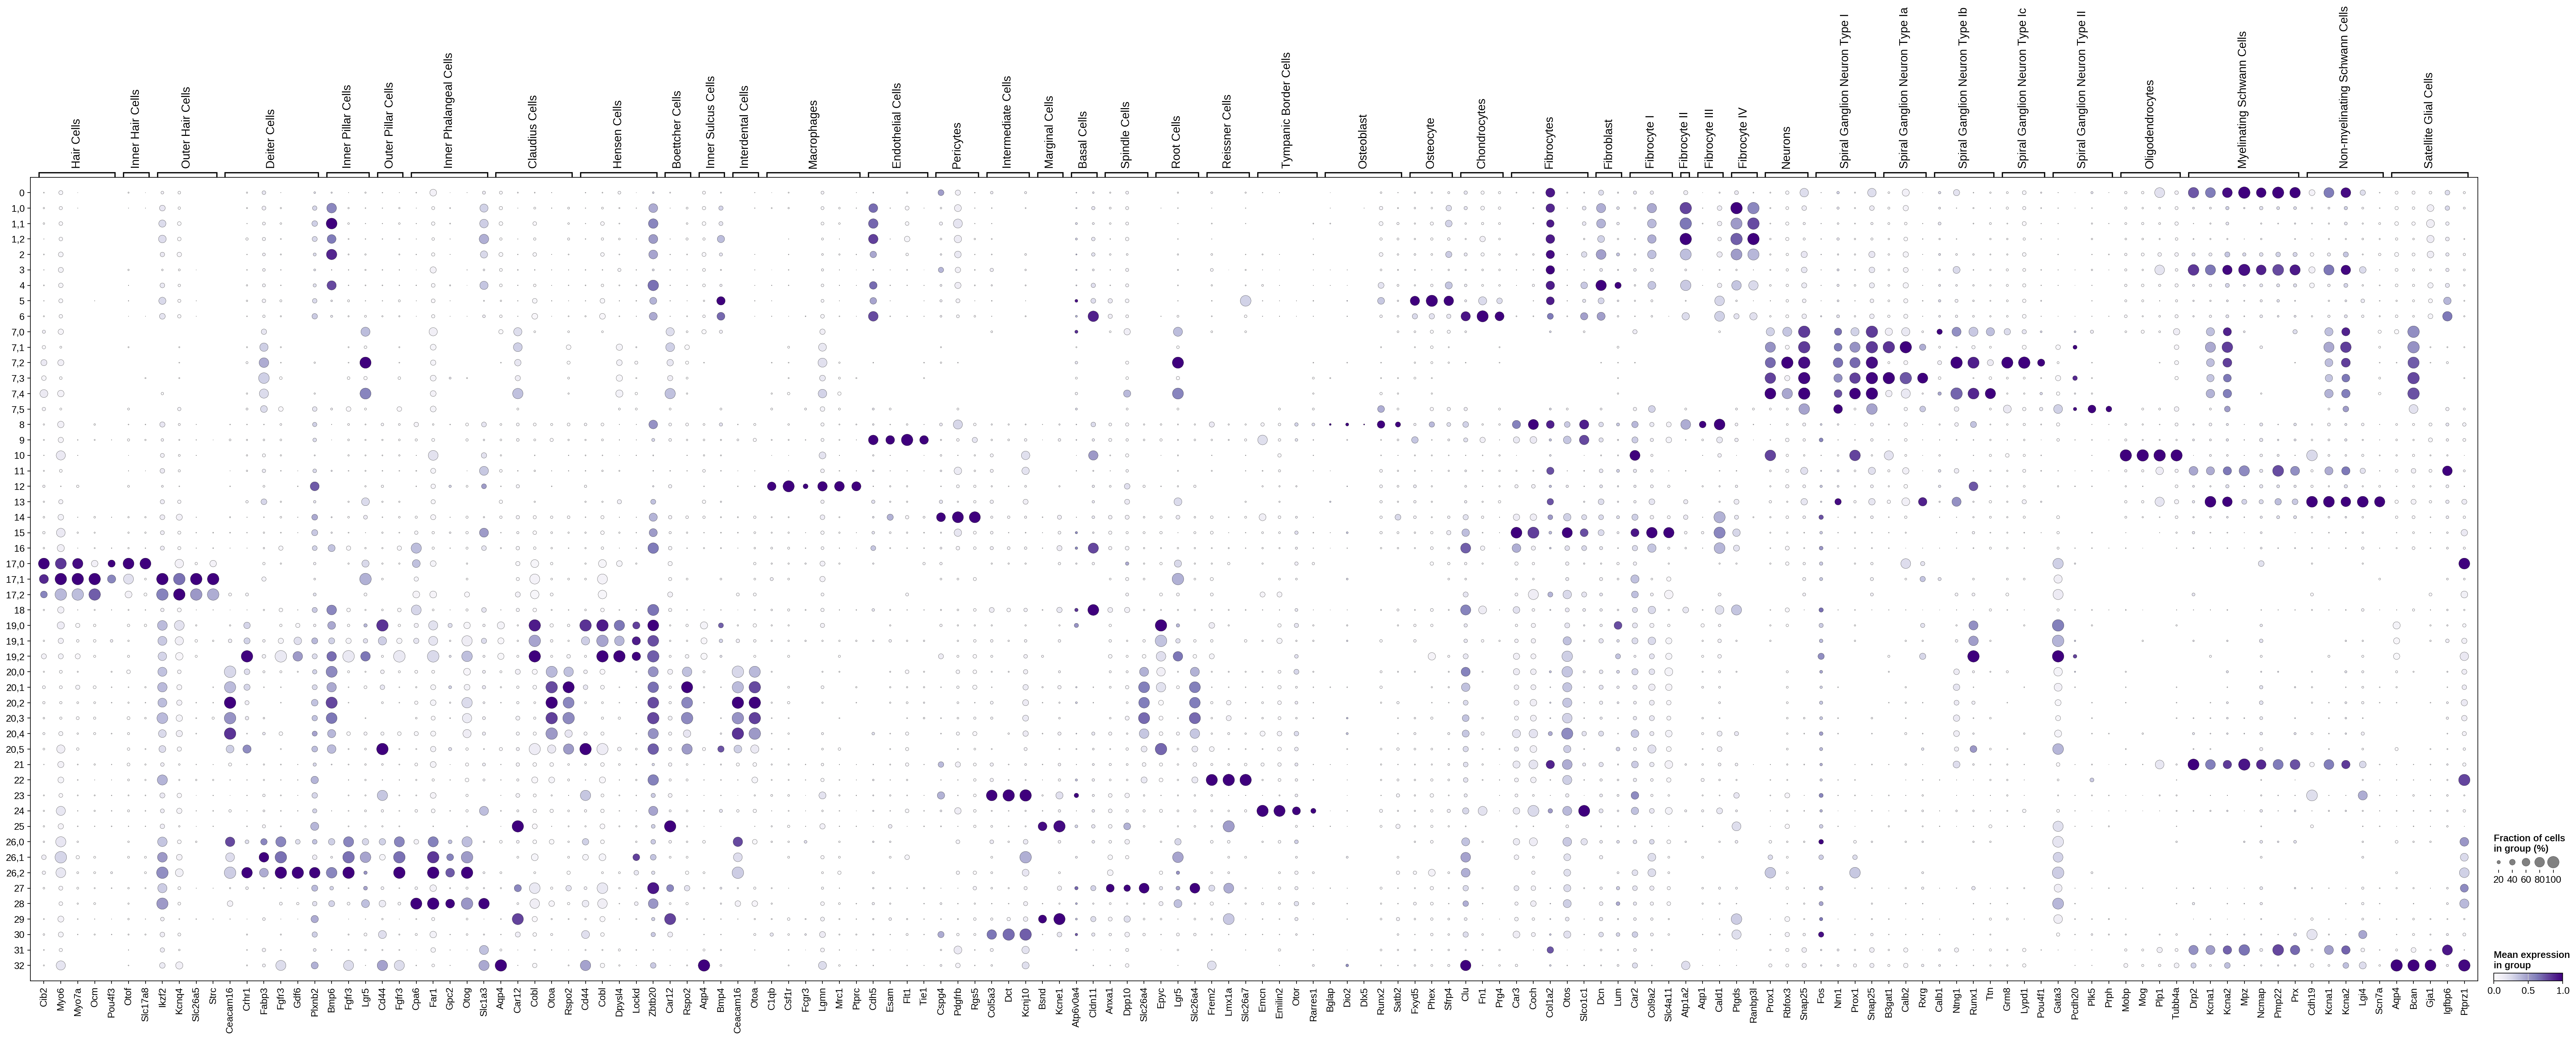

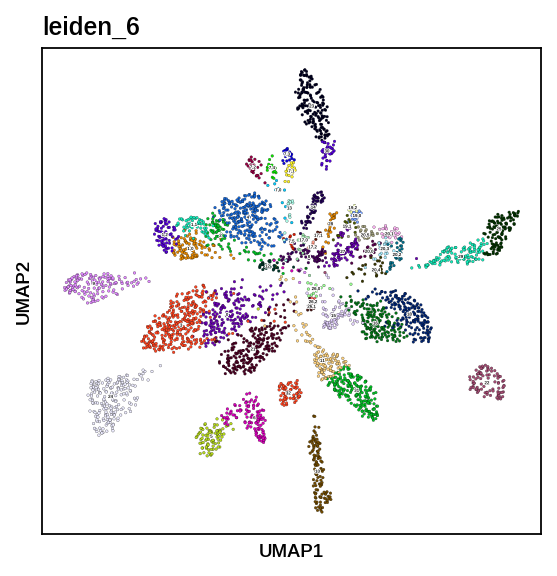

In [ ]:
# Next, we check the expression patterns of the marker genes in our clustering
sc.tl.leiden(adata,
             flavor= "igraph",
             n_iterations= -1,
             resolution= 2.6,
             key_added= "leiden_0")

# After initial inspection, defining clusters that need sub-clustering
need_subclustering = {"7": 1, # "cluster": [subclustering resolution]
                     "17": 1,
                     "19": 1,
                     "1": 0.5,
                     "20": 1,
                     "26": 1}

# Successive sub-clustering of cluters that are too coarse to tell cell types apart
i = 1
for cluster, res in need_subclustering.items():
    sc.tl.leiden(adata, flavor= "igraph", n_iterations= -1, key_added= f"leiden_{i}",
                 resolution= res,
                 restrict_to= (f"leiden_{i-1}", [cluster]))
    i += 1

# Dotplot featuring all marker genes and all the clusters to manually determine cell identities in clusters
# THIS IS WHERE THE ACTUAL CLUSTER ANNOTATION CALLING HAPPENS
sc.pl.dotplot(adata,
              markers_in_data,
              groupby=f"leiden_{len(need_subclustering)}",
              standard_scale="var",
              cmap= "Purples", # I like purple
              save= "Marker_Genes_ReferenceAtlas.png")

sc.pl.umap(adata,
           color=[f"leiden_{len(need_subclustering)}"],
           legend_loc="on data",
           legend_fontsize= 2,
           legend_fontoutline= 0.8,
           size= 6,
           palette= my_cmap.colors,
           edgecolor= "black",
           linewidth= 0.1)

### Checking Cluster Expressions

We visualise marker gene expressions on the UMAP projection to visually verify localizations.

In [ ]:
# Defining a subgroup of cell types of which to check expression levels across the whole data set
sgns = [
    "Spiral Ganglion Neuron Type Ia",
    "Spiral Ganglion Neuron Type Ib",
    "Spiral Ganglion Neuron Type Ic",
    "Spiral Ganglion Neuron Type II"]

# Now we plot marker gene expression for each marker of the above defined cell types
for ct in sgns:
    print(f"{ct.upper()}:")  # print cell subtype name
    sc.pl.umap(adata,
               color= [*markers_in_data[ct], "manual_celltypes"],
               vmax="p99",
               sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cell,
               frameon=False,
               size= 6,
               palette= my_cmap.colors,
               edgecolor= "black",
               linewidth= 0.1)

### Comitting Annotations

In [ ]:
# Committing Annotations
annotations = {"0": "Myelinating Schwann Cells 1",
                           "1,0": "Fibrocytes IV",
                           "1,1": "Fibrocytes IV",
                           "1,2": "Fibrocytes II",
                           "2": "Fibrocytes IV",
                           "3": "Myelinating Schwann Cells 1",
                           "4": "Fibroblasts",
                           "5": "Osteocytes",
                           "6": "Chondrocytes",
                           "7,1": "Spiral Ganglion Neuron Type Ia",
                           "7,3": "Spiral Ganglion Neuron Type Ia",
                           "7,0": "Spiral Ganglion Neuron Type Ib",
                           "7,4": "Spiral Ganglion Neuron Type Ib",
                           "7,2": "Spiral Ganglion Neuron Type Ic",
                           "7,5": "Spiral Ganglion Neuron Type II",
                           "8": "Fibrocytes III",
                           "9": "Endothelial Cells",
                           "10": "Oligodendrocytes",
                           "11": "Satellite Glial Cells 1",
                           "12": "Macrophages",
                           "13": "Non-myelinating Schwann Cells",
                           "14": "Pericytes",
                           "15": "Fibrocytes I",
                           "16": "Basal Cells",
                           "17,0": "Inner Hair Cells",
                           "17,1": "Outer Hair Cells",
                           "17,2": "Outer Hair Cells",
                           "18": "Basal Cells",
                           "19,0": "Root Cells",
                           "19,1": "Hensen Cells",
                           "19,2": "Hensen Cells",
                           "20,0": "Claudius Cells",
                           "20,1": "Claudius Cells",
                           "20,2": "Interdental Cells",
                           "20,3": "Claudius Cells",
                           "20,4": "Interdental Cells",
                           "20,5": "Claudius Cells",
                           "21": "Myelinating Schwann Cells 2",
                           "22": "Reissner Cells",
                           "23": "Intermediate Cells",
                           "24": "Tympanic Border Cells",
                           "25": "Marginal Cells",
                           "26,0": "Pillar Cells",
                           "26,1": "Pillar Cells",
                           "26,2": "Deiter Cells",
                           "27": "Spindle Cells",
                           "28": "Inner Phalangeal Cells",
                           "29": "Marginal Cells",
                           "30": "Intermediate Cells",
                           "31": "Satellite Glial Cells 1",
                           "32": "Satellite Glial Cells 2"}

# Refactoring the cluster identity and saving it to a new annotation as cell types
adata.obs["manual_celltypes"] = adata.obs["leiden_6"].map(annotations)

# Saving the annotated dataset
adata.write_h5ad(r"C:\Users\Johann\Documents\Coding\Python\Master Thesis\Data\CBA_3mo_CompleteCochlea_Atlas_Annotated_Johann.h5ad")

# Plotting our pretty little clusters

fig, ax = plt.subplots(1,1, figsize=(fig_width*2.5, fig_width), layout= "compressed")

sc.pl.umap(adata,
           color=["manual_celltypes"],
           edgecolor= "black",
           linewidth= 0.15,
           size= 10,
           palette= my_cmap.colors,
           legend_fontsize= 6*scale,
           ax = ax,
           show= False)
ax.set_title("Reference Atlas (whole cochlea, 3 months)", fontsize= 10)

fig.savefig(figures_folder + r"\Cochlea_Atlas_Annotated.png")
plt.show()

## Gene Expression Analysis

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(fig_width*2.5, fig_width), layout= "compressed")

sc.pl.umap(adata,
           color=["manual_celltypes"],
           edgecolor= "black",
           linewidth= 0.15,
           size= 10,
           palette= my_cmap.colors,
           legend_fontsize= 6*scale,
           ax = ax,
           show= False)
ax.set_title("Reference Atlas (whole cochlea, 3 months)", fontsize= 10)

fig.savefig(figures_folder + r"\Cochlea_Atlas_Annotated.png")
plt.show()

c:\Users\jkorn\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_anndata.py:967: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\jkorn\AppData\Local\Temp\ipykernel_20760\1289294159.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i+1, 1].set_xticklabels([""])
c:\Users\jkorn\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_anndata.py:967: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\jkorn\AppData\Local\Temp\ipykernel_20760\1289294159.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. 

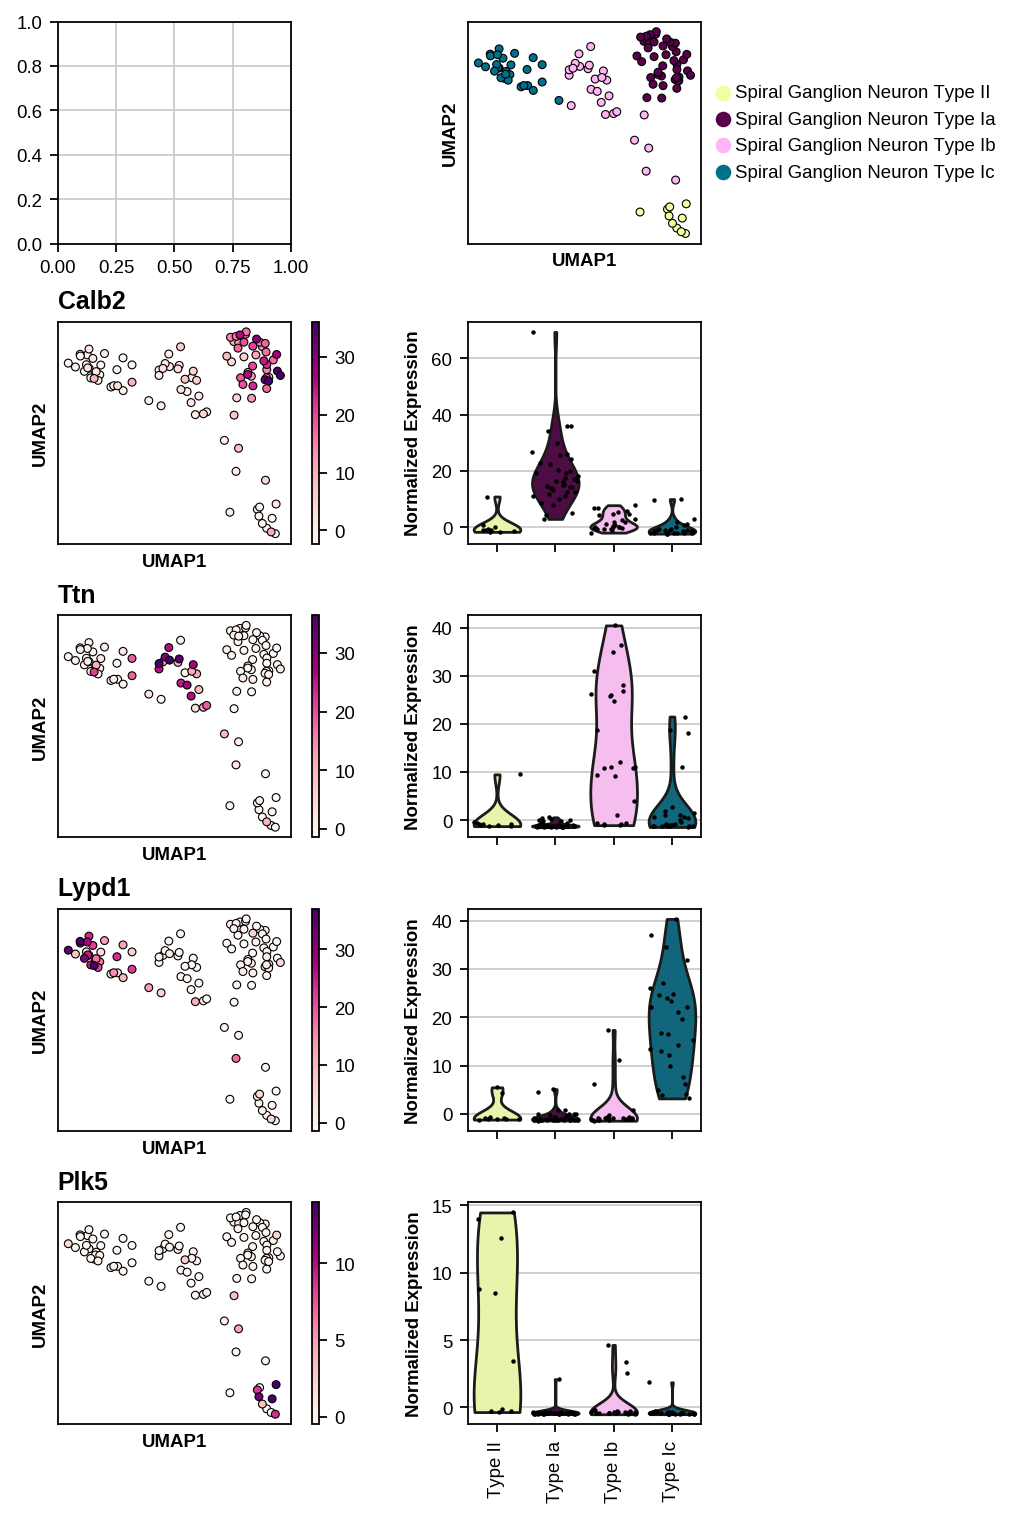

In [19]:
# Plotting expressions of SGN marker genes
# Only within the SGN cluster

adata = sc.read_h5ad(r"C:\Users\jkorn\Documents\Coding\Python\Master Thesis Data\Data\CBA_3mo_CompleteCochlea_Atlas_Annotated_Johann.h5ad")
adata_SGNonly = adata[adata.obs["manual_celltypes"].str.contains("Type I")].copy()
markers_to_plot = ["Calb2", # Type Ia
                   "Ttn",   # Type Ib
                   "Lypd1", # Type Ic
                   "Plk5"]  # Type II

fig, axes = plt.subplots(5,2, figsize=(fig_width*1.9, fig_width*2.85),
                         layout= "compressed",
                         gridspec_kw= {"wspace": 0.1})

dot_size = 50
line_width = 0.5
vmax = "p99"
sc.pl.umap(adata_SGNonly,
           color=["manual_celltypes"],
           edgecolor= "black",
           linewidth= line_width,
           size= dot_size,
           palette= my_cmap.colors[30:34],
           ax= axes[0,1],
           show= False,
           vmax= vmax,
           title= "")

for i, mark in enumerate(markers_to_plot):
    # Type Ia (B3gat1, Calb2)
    sc.pl.umap(adata_SGNonly,
               color= mark,
               size= dot_size,
               vmax= vmax,
               legend_loc= "none",
               edgecolor= "black",
               linewidth= line_width,
               ax= axes[i+1, 0],
               title= "",
               show= False)
    axes[i+1, 0].set_title(mark, fontsize= 8*scale)
    
    sc.pl.violin(adata_SGNonly,
                 mark,
                 groupby= "manual_celltypes",
                 jitter= 0.4,
                 size= 2,
                 palette= my_cmap.colors[30:34],
                 ax= axes[i+1, 1],
                 rotation= 90,
                 ylabel= "",
                 zorder= 2,
                 show= False)
    axes[i+1, 1].set_xticklabels([""])
    axes[i+1, 1].set_title("")
    axes[i+1, 1].set_ylabel("Normalized Expression")
else:
    axes[i+1, 1].set_xticklabels(["Type II", "Type Ia", "Type Ib", "Type Ic"])

fig.savefig(figures_folder + r"\Marker_Gene_Expressions.png")
plt.show()

## Gene Expression Analysis

I use the annotations to filter out the cells of interest (SGN Type I) and plot their normalized gene expression across age groups (wherever available). Furthermore we look at general differential expression between age groups in certain cell types.

c:\Users\jkorn\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\jkorn\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\jkorn\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\jkorn\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\jkorn\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: inv

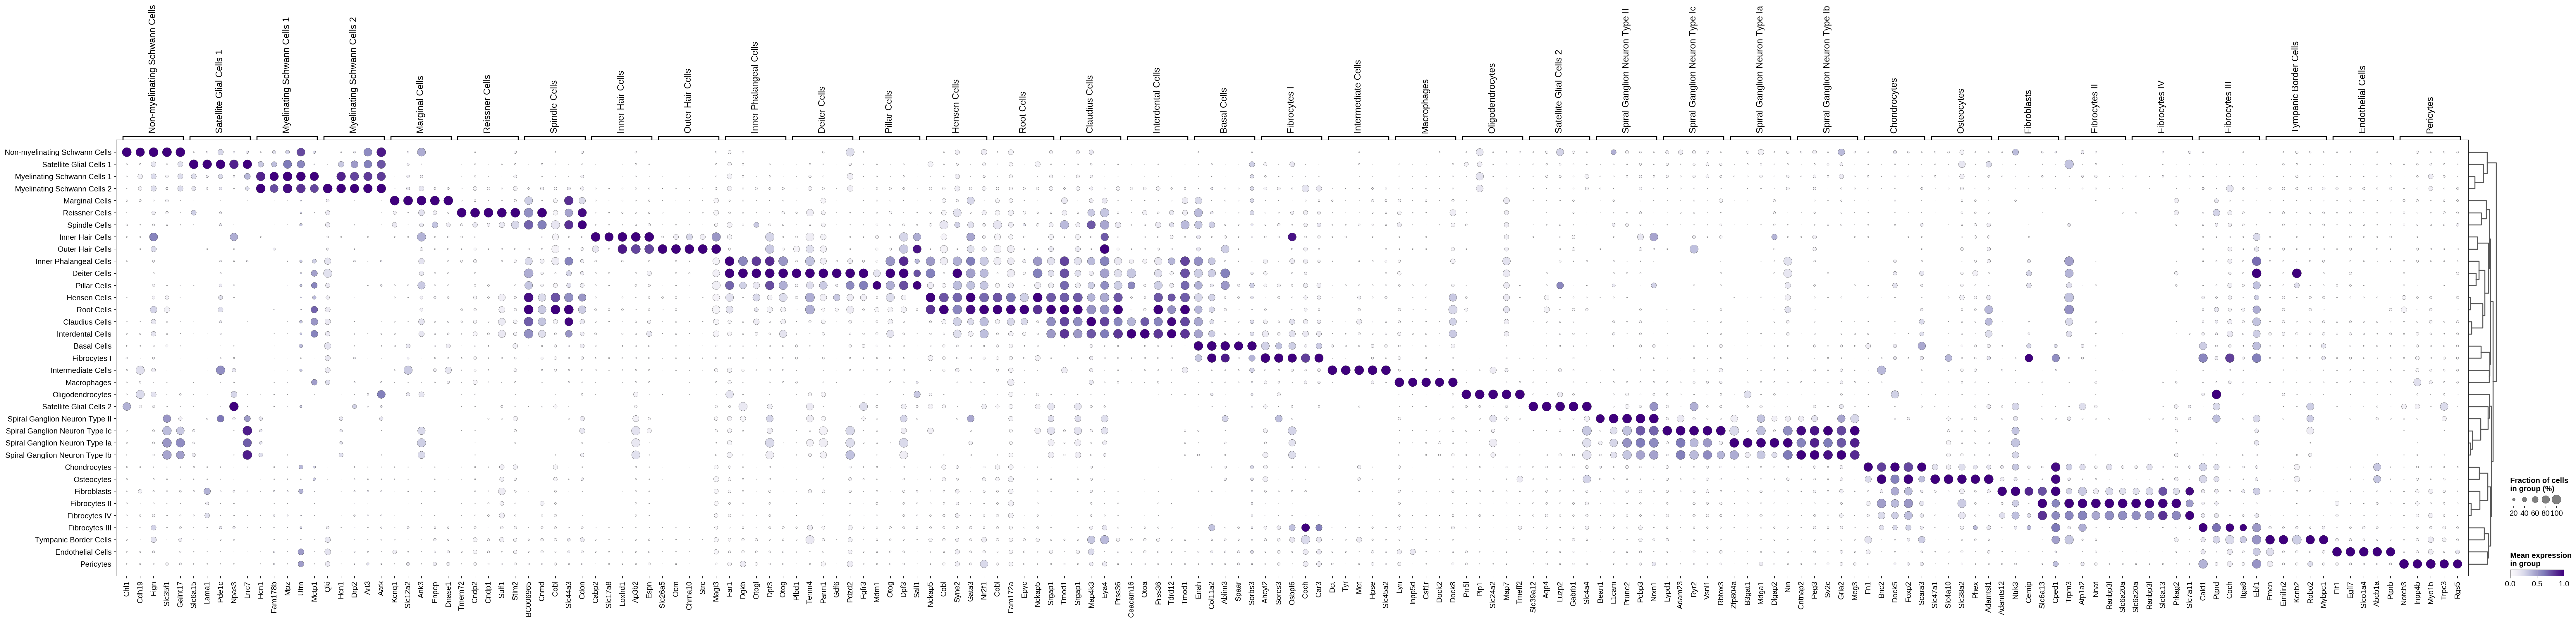

In [25]:
sc.tl.rank_genes_groups(adata,
                        groupby="manual_celltypes",
                        method="wilcoxon",
                        key_added="dea_leiden") # The gene groups key

sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="manual_celltypes",
    standard_scale="var",
    n_genes=5,
    key="dea_leiden",
    cmap= "Purples",
    save= r"unsupervised_markers_ReferenceAtlas.png")

In [ ]:
# Now we can visualize these unsupervised found genes across the whole dataset
cell_type = "Spiral Ganglion Neuron Type Ia"
new_markers = sc.get.rank_genes_groups_df(adata, group= [cell_type])

sc.pl.umap(adata,
           color= new_markers["names"].to_list(),
           sort_order=False,
           vmin= "p1",
           size= 6,
           edgecolor= "black",
           linewidth= 0.1)

new_markers